# Car Type CNN Classification

The dataset can be downloaded from [here](https://hometeamsnt-my.sharepoint.com/personal/benjamin_cham_hometeamsnt_onmicrosoft_com/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fbenjamin%5Fcham%5Fhometeamsnt%5Fonmicrosoft%5Fcom%2FDocuments%2FStanford%20Cars%20Dataset%2Ezip&parent=%2Fpersonal%2Fbenjamin%5Fcham%5Fhometeamsnt%5Fonmicrosoft%5Fcom%2FDocuments&ga=1). 

Notebook Task Requirements:
- Explain the data pre-processing steps
- Clearly state the model used
- List and explain any assumptions you have made about the requirements
- Explain the model training process
- Present the final training and validation results (confusion matrix, graph output, etc.)
- Save the trained model in either .pth or .pt(Pytorch) , h5 or .hdf5 (Tensorflow)
- Provide the necessary python environment and dependencies (i.e., conda or pip)

## Import Libraries

Note: Tensorflow with CUDA/cuDNN on WSL2 was installed to use my PC's RTX 3060 during model training and testing. Inference through the FastAPI endpoint will be run on CPU instead as it is fast enough and GPU might not be available on users' machines and will require a base image with CUDA/cuDNN support.

In [2]:
import tensorflow as tf

# Check if GPU is available
print(tf.config.list_physical_devices('GPU'))

2023-04-23 13:50:22.595039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 13:50:22.903067: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-23 13:50:23.838692: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/zhermin/anaconda3/lib/:/home/zhermin/.local/lib/python3.10/site-packages/nvidia/cudnn/lib:/home/zhermin/anaconda3/lib/:/home/zhermin/.local/lib/python3.10/site-packages/nvidia/cudnn/lib
2023-04-23 13:50:23

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-04-23 13:50:25.376288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-23 13:50:25.468268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-23 13:50:25.468466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.


In [32]:
from pathlib import Path
from PIL import Image
import base64
import io

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preprocessing

### Read Data

Also 0-index the classes from 1-196 to 0-195 to use the `class_names` list much easier

In [6]:
class_names = pd.read_csv("Stanford Cars Dataset/annotations/class_names.csv", header=None)
class_names = class_names[0].tolist()
class_names[:5]

['AM General Hummer SUV 2000',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012']

In [38]:
df = pd.read_csv("Stanford Cars Dataset/annotations/cars_annos.csv", sep=";")
df["class"] -= 1  # 0-indexing
df.head()

,Image,x1,y1,x2,y2,class,test
0,000001.jpg,112,7,853,717,0,0
1,000002.jpg,48,24,441,202,0,0
2,000003.jpg,7,4,277,180,0,0
3,000004.jpg,33,50,197,150,0,0
4,000005.jpg,5,8,83,58,0,0


### Class Balancing

I noticed one of the classes has a much higher count than the rest, which might cause some bias towards that particular class if all its data was used to train the model. 

The simple solution I did was to just undersample that class. I could also have oversampled the rest or performed data augmentation to alleviate some of these class imbalance issues but I didn't had much time to further tune the model.

(16185, 7)


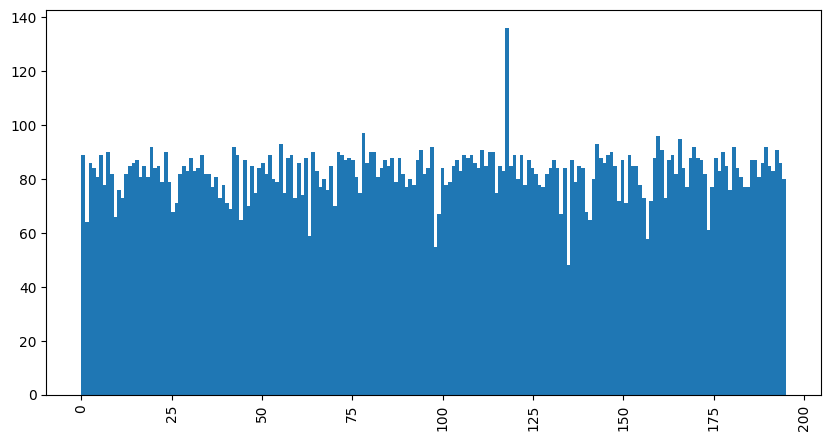

In [39]:
# plot the class distribution

print(df.shape)
plt.figure(figsize=(10, 5))
plt.hist(df["class"], bins=196)
plt.xticks(rotation=90)
plt.show()

Top 3 Most Frequent Classes:
 class
118    136
78      97
160     96
Name: count, dtype: int64
Outlier class: #118 (GMC Savana Van 2012)
Average number of samples per class: 82


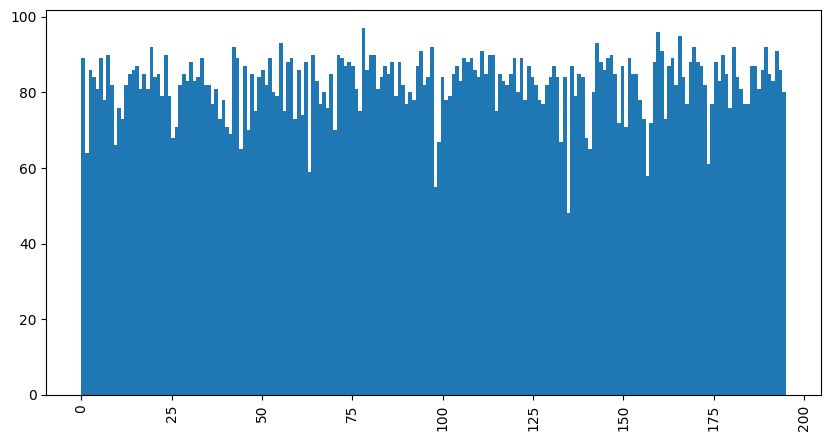

In [40]:
# find and deal with the outlier class by undersampling

print("Top 3 Most Frequent Classes:\n", df["class"].value_counts().head(3))
outlier = df["class"].value_counts().index[0]
print(f"Outlier class: #{outlier} ({class_names[outlier]})")

# calculate average number of samples per class without the outlier

avg = int(df[df["class"] != outlier]["class"].value_counts().mean())
print(f"Average number of samples per class: {avg}")

# undersample the outlier class

df = pd.concat([
    df[df["class"] == outlier].sample(avg, random_state=42),
    df[df["class"] != outlier]
], axis=0)

# sort back the dataframe by image name

df = df.sort_values(by="Image").reset_index(drop=True)

# plot the class distribution again

plt.figure(figsize=(10, 5))
plt.hist(df["class"], bins=196)
plt.xticks(rotation=90)
plt.show()

In [41]:
print(df.shape)
df.head()

(16131, 7)


,Image,x1,y1,x2,y2,class,test
0,000001.jpg,112,7,853,717,0,0
1,000002.jpg,48,24,441,202,0,0
2,000003.jpg,7,4,277,180,0,0
3,000004.jpg,33,50,197,150,0,0
4,000005.jpg,5,8,83,58,0,0


## Model Training

### Pretrained Model Selected

EfficientNet V2 B3

### Stats (from [Keras](https://keras.io/api/applications/))

| Model          | Size (MB) | Top-1 Accuracy | Top-5 Accuracy | Parameters | Depth | Time (ms) per inference step (CPU) | Time (ms) per inference step (GPU) |
|----------------|----------:|---------------:|---------------:|-----------:|------:|-----------------------------------:|-----------------------------------:|
| EfficientNetB3 |        48 |          81.6% |          95.7% |      12.3M |   210 |                              140.0 |                                8.8 |

### Image Input Size (from [Source Code](https://pypi.org/project/keras-efficientnet-v2/))

300 x 300

### Reasons

I chose this model because it had pretty good top-1 and top-5 accuracies but also not too big (< 100MB to upload to GitHub) and also quite fast. Using a bigger model might not be better by default so this were the tradeoffs that I considered.

The other models would have been fine as well as the main advantage is that these pretrained models have been trained on ImageNet, which should be robust enough for a simple demo with little fine-tuning.

Moreover, assumably based on the requirements, there aren't any hard requirements like model size (eg. if to be served on mobile or low compute devices) or speed. Nonetheless, further optimizations can be done at a later stage anyway if need be, such as pruning or quantization to reduce the model size and changing to other model formats like ONXX for interoperability.

/home/zhermin/car-classifier/Stanford Cars Dataset/car_ims


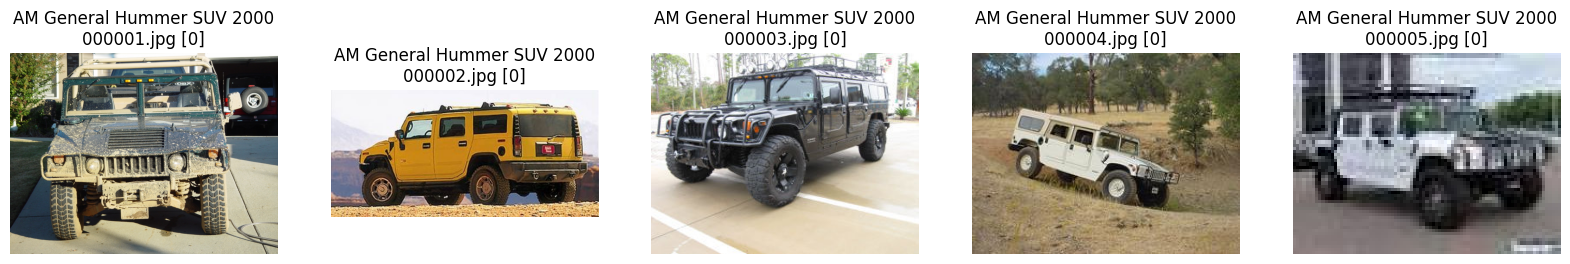

In [11]:
# filter out the outlier images from the data path as well

data_path = Path.joinpath(Path.cwd(), "Stanford Cars Dataset", "car_ims")
print(data_path)

# preview the images

fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    img = Image.open(data_path / df.iloc[i]["Image"])
    ax[i].imshow(img)
    ax[i].set_title(f"{class_names[df.iloc[i]['class']]}\n{df.iloc[i]['Image']} [{df.iloc[i]['class']}]")
    ax[i].axis("off")

plt.show()

### Params and Hyperparams

Since there wasn't much time or need to fine-tune the model, I just used mostly defaults and also split into train and val sets without an explicit test set to fully utilize all the data (restricted to this Stanford Cars Dataset only).

In [12]:
# parameters

# MODEL = EfficientNetV2B3
IMG_SIZE = 300
NUM_CLASSES = len(class_names)
SEED = 42

# hyperparameters

BATCH_SIZE = 64
EPOCHS = 20
VALIDATION_SPLIT = 0.2

### Data Preprocessing

Again, because there wasn't much fine-tuning involved, the data preprocessing steps are quite straightforward:

- Load the data without the outlier into a `Dataset` and shuffle it once
- 80%/20% Train/Val Split with no shuffling or data augmentations
- Resize to 300x300, which is the expected size for EfficientNetV2B3
- Use `efficientnet_v2.preprocess_input` to preprocess the images automatically based on the model's requirements such as rescaling to 1.0/255
- Set up batching and autotuned prefetching for efficient training on the datasets

In [13]:
# preprocessing

image_filenames = [str(data_path.joinpath(fname)) for fname in df["Image"].tolist()]
label_names = df["class"].tolist()

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, label_names))
dataset = dataset.shuffle(buffer_size=len(image_filenames), reshuffle_each_iteration=False)

# preprocessing function

def preprocess_image(filename: str, label: str) -> tuple[tf.Tensor, str]:
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.keras.applications.efficientnet_v2.preprocess_input(image)  # preprocess according to EfficientNetV2
    return image, label

val_size = int(len(image_filenames) * VALIDATION_SPLIT)
train_ds = dataset.skip(val_size)
val_ds = dataset.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

# map the preprocessing function to the dataset

train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

# batch the dataset

train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

# prefetch the dataset

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

2023-04-23 13:50:43.024457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 13:50:43.025878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-23 13:50:43.026080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-23 13:50:43.026216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built witho

12905
3226
Image shape:  (300, 300, 3)
Label:  159


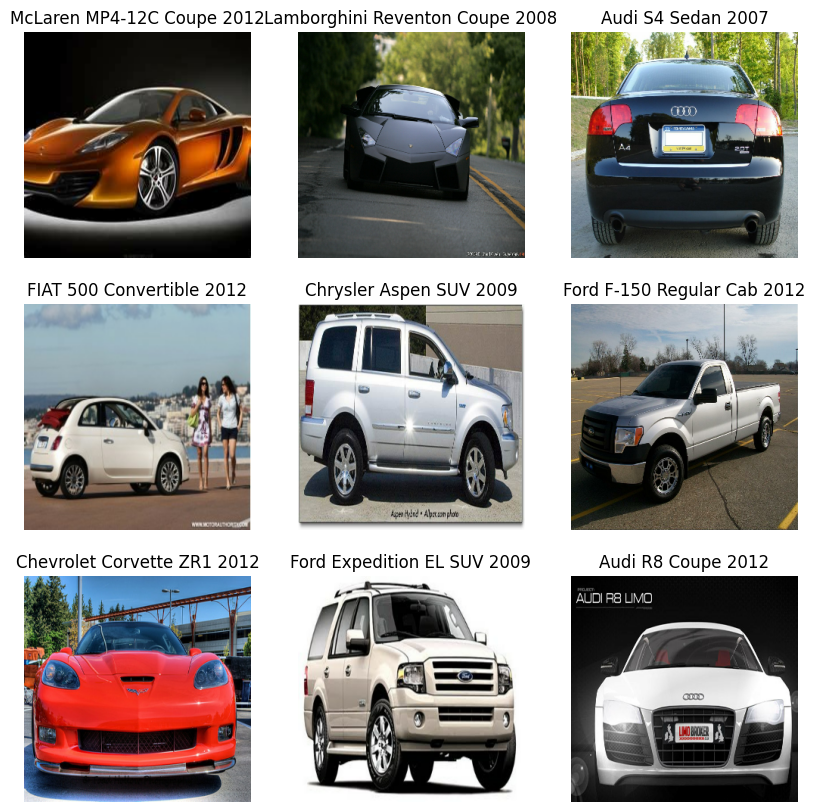

In [14]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[int(label_batch[i])])
    plt.axis("off")

### Model Compilation

Use the model's pretrained weights from `imagenet` and freeze all but the final 2 layers so that the model can be used to predict on our use-case of 196 classes instead of `imagenet`'s 1000 classes by adding a simple FC layer with 196 neurons and softmax activation to get the probabilities for each class.

We can confirm that we only have around 2.3% of trainable parameters in the model, total 13,231,874, using `model.summary()`. Hence, most of the learnings from `imagenet` will still be present.

In [15]:
# create model

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(
    include_top=True,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)

# only finetune last 2 layers for our 196 classes instead of 1000 and freeze the rest
for layer in base_model.layers[:-2]:
    layer.trainable = False

x = base_model.layers[-2].output
output = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 300, 300, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 300, 300, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 150, 150, 40  1080        ['normalization[0][0]']      

### Model Training

After compiling the model, we can easily fit it on our train/val dataset. The history output of `model.fit` is also saved so that we can visualize the training and also continue from any particular epoch later on.

Usually `tensorboard` can also be used to track the training a bit easier as it provides an interactive visualization dashboard but more setup is needed so it wasn't used for this simple demo. 

In [29]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/20
202/202 [==============================] - 58s 257ms/step - loss: 4.1235 - accuracy: 0.1285 - val_loss: 3.3324 - val_accuracy: 0.2452
Epoch 2/20
202/202 [==============================] - 50s 248ms/step - loss: 3.0337 - accuracy: 0.3281 - val_loss: 2.8031 - val_accuracy: 0.3642
Epoch 3/20
202/202 [==============================] - 50s 246ms/step - loss: 2.5547 - accuracy: 0.4373 - val_loss: 2.5008 - val_accuracy: 0.4312
Epoch 4/20
202/202 [==============================] - 50s 247ms/step - loss: 2.2450 - accuracy: 0.5021 - val_loss: 2.3007 - val_accuracy: 0.4746
Epoch 5/20
202/202 [==============================] - 50s 248ms/step - loss: 2.0169 - accuracy: 0.5551 - val_loss: 2.1408 - val_accuracy: 0.5127
Epoch 6/20
202/202 [==============================] - 50s 249ms/step - loss: 1.8448 - accuracy: 0.5865 - val_loss: 2.0270 - val_accuracy: 0.5332
Epoch 7/20
202/202 [==============================] - 50s 248ms/step - loss: 1.6914 - accuracy: 0.6251 - val_loss: 1.9345 - val_ac

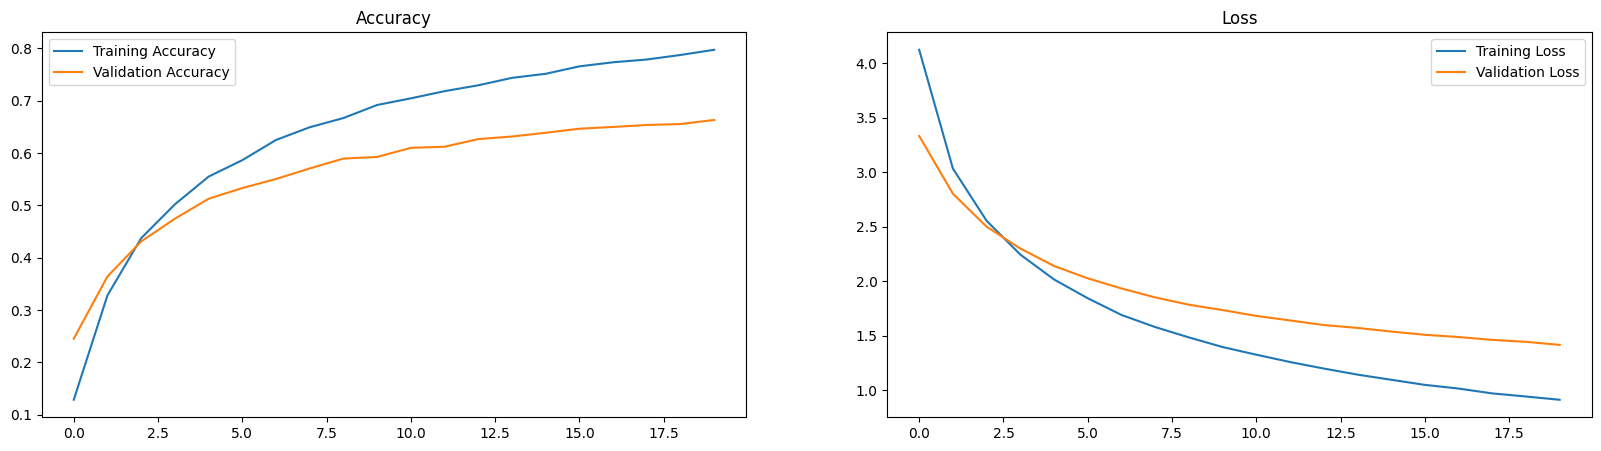

In [34]:
# plot the accuracy and loss curves side by side

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].plot(history.history["accuracy"], label="Training Accuracy")
ax[0].plot(history.history["val_accuracy"], label="Validation Accuracy")
ax[0].legend()
ax[0].set_title("Accuracy")

ax[1].plot(history.history["loss"], label="Training Loss")
ax[1].plot(history.history["val_loss"], label="Validation Loss")
ax[1].legend()
ax[1].set_title("Loss")

plt.show()

In [36]:
# save the model

model.save("models/effnetv2b3-batch64-ep20.h5")

### Preliminary Tests

We can perform some preliminary tests to see if the model is working as expected before continuing further.

In [38]:
# load the model

test_model = tf.keras.models.load_model("models/effnetv2b3-batch64-ep20.h5")

# test the model

test_image = Image.open(data_path / df.iloc[0]["Image"])
test_image = test_image.resize((IMG_SIZE, IMG_SIZE))
test_image = np.array(test_image)
test_image = tf.keras.applications.efficientnet_v2.preprocess_input(test_image)
test_image = np.expand_dims(test_image, axis=0)

pred = test_model.predict(test_image)
pred = np.argmax(pred, axis=1)
print(f"Predicted class: {class_names[pred[0]]}")

# test the model on a batch of images

test_image_batch = image_batch
pred = test_model.predict(test_image_batch)
pred = np.argmax(pred, axis=1)
print(f"Predicted classes: {[class_names[p] for p in pred]}")

# test the model on the validation set

test_image_batch, test_label_batch = next(iter(val_ds))
pred = test_model.predict(test_image_batch)
pred = np.argmax(pred, axis=1)
print(f"Predicted classes: {[class_names[p] for p in pred]}")

1/1 [==============================] - 1s 1s/step
Predicted class: AM General Hummer SUV 2000
2/2 [==============================] - 2s 95ms/step
Predicted classes: ['Ford E-Series Wagon Van 2012', 'Chrysler Crossfire Convertible 2008', 'Lincoln Town Car Sedan 2011', 'GMC Terrain SUV 2012', 'Bentley Continental Supersports Conv. Convertible 2012', 'Land Rover Range Rover SUV 2012', 'Buick Regal GS 2012', 'Audi A5 Coupe 2012', 'Mercedes-Benz E-Class Sedan 2012', 'GMC Canyon Extended Cab 2012', 'Volvo 240 Sedan 1993', 'Hyundai Azera Sedan 2012', 'Audi 100 Wagon 1994', 'Audi 100 Sedan 1994', 'Volkswagen Beetle Hatchback 2012', 'Plymouth Neon Coupe 1999', 'Chevrolet Corvette ZR1 2012', 'Dodge Ram Pickup 3500 Quad Cab 2009', 'BMW 1 Series Coupe 2012', 'Chevrolet Cobalt SS 2010', 'GMC Canyon Extended Cab 2012', 'Chevrolet Monte Carlo Coupe 2007', 'Dodge Durango SUV 2007', 'Suzuki Aerio Sedan 2007', 'Geo Metro Convertible 1993', 'Dodge Journey SUV 2012', 'Ford F-150 Regular Cab 2012', 'Aston 

### Continue Training 1

With 20 epochs, we can see if the model is working for our data. A small number of epochs was used to check if the model is learning, ie. not have terrible acc/loss and at least overfit on the training data. 

In this case it turned out really well and both train/val curves were improving steadily with the training curves being better than the validation curves, which is a good sign as it means that the validation dataset has a good selection and is not so easy to the point where val acc > train acc.

Either way the curves show that the models can still improve a lot as they are very smooth improvement curves. Hence, I continued training an additional 30 epochs to see if progress starts to halt or overfitting occurs.

In [39]:
# continue training the model to epoch 50

history = test_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    initial_epoch=history.epoch[-1]
)

Epoch 20/50
202/202 [==============================] - 55s 255ms/step - loss: 0.8874 - accuracy: 0.8003 - val_loss: 1.4124 - val_accuracy: 0.6584
Epoch 21/50
202/202 [==============================] - 50s 249ms/step - loss: 0.8557 - accuracy: 0.8065 - val_loss: 1.3891 - val_accuracy: 0.6637
Epoch 22/50
202/202 [==============================] - 51s 250ms/step - loss: 0.8362 - accuracy: 0.8134 - val_loss: 1.3723 - val_accuracy: 0.6742
Epoch 23/50
202/202 [==============================] - 51s 251ms/step - loss: 0.8203 - accuracy: 0.8164 - val_loss: 1.3703 - val_accuracy: 0.6711
Epoch 24/50
202/202 [==============================] - 50s 249ms/step - loss: 0.7869 - accuracy: 0.8222 - val_loss: 1.3519 - val_accuracy: 0.6767
Epoch 25/50
202/202 [==============================] - 50s 248ms/step - loss: 0.7639 - accuracy: 0.8287 - val_loss: 1.3433 - val_accuracy: 0.6739
Epoch 26/50
202/202 [==============================] - 50s 247ms/step - loss: 0.7521 - accuracy: 0.8275 - val_loss: 1.3284 -

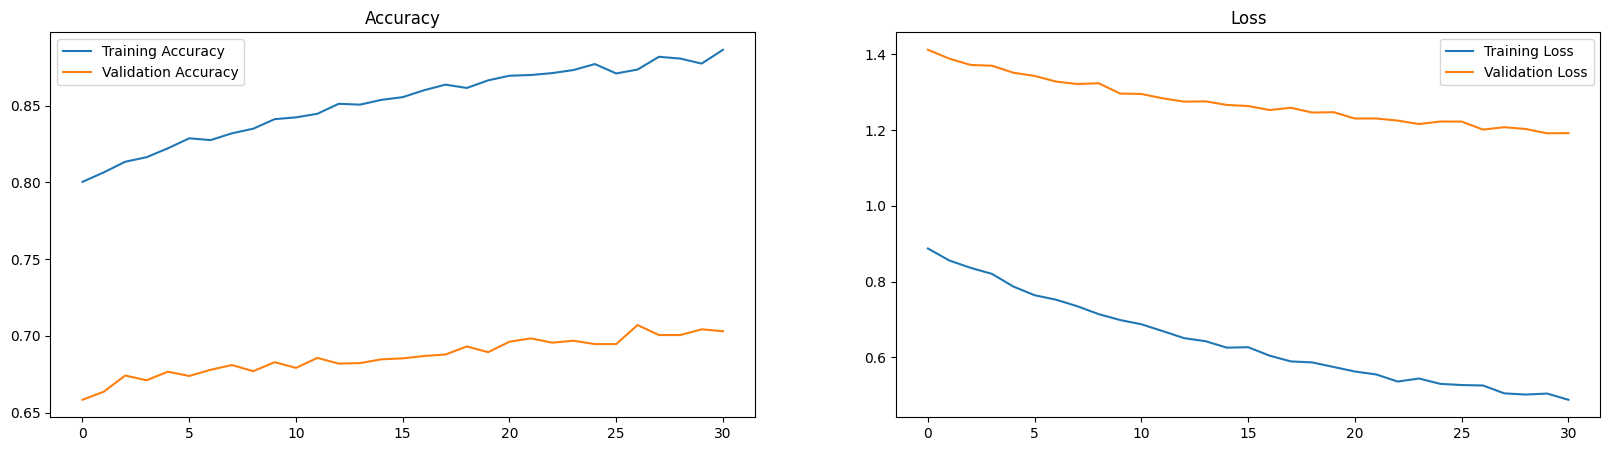

In [40]:
# plot the accuracy and loss curves side by side

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].plot(history.history["accuracy"], label="Training Accuracy")
ax[0].plot(history.history["val_accuracy"], label="Validation Accuracy")
ax[0].legend()
ax[0].set_title("Accuracy")

ax[1].plot(history.history["loss"], label="Training Loss")
ax[1].plot(history.history["val_loss"], label="Validation Loss")
ax[1].legend()
ax[1].set_title("Loss")

plt.show()

In [41]:
test_model.save("models/effnetv2b3-batch64-ep50.h5")

### Continue Training 2

Up to epoch 50, we can see some signs of the improvements slowing down but surprisingly it still looked like it had more to go as the end of epoch 50 was still the best it has seen yet. Hence, I did one final round of training to push it to 120 epochs, which should be satisfactory. 

There was however a risk here that running so many more epochs might cause the model to overfit a lot suddenly. Normally I would use tensorflow callbacks here to save the best model or do early stops to avoid overfitted models but I didn't had much time.

In [46]:
# continue training the model to epoch 120

test_model = tf.keras.models.load_model("models/effnetv2b3-batch64-ep50.h5")

history = test_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=120,
    initial_epoch=history.epoch[-1]
)

Epoch 50/120
202/202 [==============================] - 54s 253ms/step - loss: 0.4905 - accuracy: 0.8861 - val_loss: 1.1922 - val_accuracy: 0.7086
Epoch 51/120
202/202 [==============================] - 50s 246ms/step - loss: 0.4739 - accuracy: 0.8852 - val_loss: 1.1916 - val_accuracy: 0.7061
Epoch 52/120
202/202 [==============================] - 50s 247ms/step - loss: 0.4705 - accuracy: 0.8879 - val_loss: 1.2015 - val_accuracy: 0.7012
Epoch 53/120
202/202 [==============================] - 50s 247ms/step - loss: 0.4671 - accuracy: 0.8864 - val_loss: 1.1898 - val_accuracy: 0.7033
Epoch 54/120
202/202 [==============================] - 50s 246ms/step - loss: 0.4621 - accuracy: 0.8871 - val_loss: 1.1950 - val_accuracy: 0.7009
Epoch 55/120
202/202 [==============================] - 50s 247ms/step - loss: 0.4653 - accuracy: 0.8856 - val_loss: 1.1821 - val_accuracy: 0.7021
Epoch 56/120
202/202 [==============================] - 50s 247ms/step - loss: 0.4454 - accuracy: 0.8929 - val_loss: 1

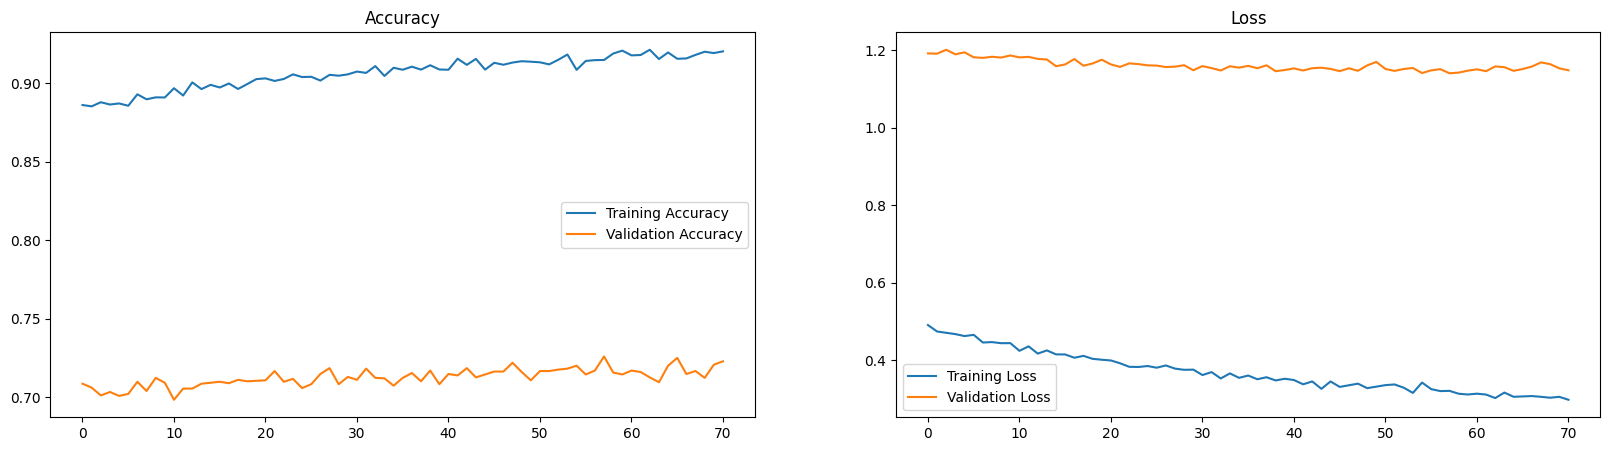

In [47]:
# plot the accuracy and loss curves side by side

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].plot(history.history["accuracy"], label="Training Accuracy")
ax[0].plot(history.history["val_accuracy"], label="Validation Accuracy")
ax[0].legend()
ax[0].set_title("Accuracy")

ax[1].plot(history.history["loss"], label="Training Loss")
ax[1].plot(history.history["val_loss"], label="Validation Loss")
ax[1].legend()
ax[1].set_title("Loss")

plt.show()

In [48]:
test_model.save("models/effnetv2b3-batch64-ep120.h5")

In [17]:
test_model = tf.keras.models.load_model("models/effnetv2b3-batch64-ep120.h5")

### Model Inference

Thankfully the epoch 120 model didn't overfit too much suddenly but progress has mostly stopped. It might still be able to be trained a bit more but this could also cause more overfitting and perform worse on new data (non-train and non-val data). 

With this final model we can save it to a `.h5` or `.hdf5` a file for inference and serve it through an API as well later.

Prediction is pretty straightforward, we just predict on the entire dataset since we don't have a test set. The confusion matrix plotted below is a bit hard to visualize even with a heatmap but the dark diagonal does indicate that most of the predictions were correct. 

I also used a `classification_report` to give a better way to see the results in a table form, which also includes the macro accuracy to give a more comprehensive overview of the model performance, which is around 94%. The report is saved into the `/reports` folder.

Since no test set was used to evaluate the model more fairly, the 94% accuracy can be a bit misleading. But I think in general it should perform fine especially if the new test images don't differ too much from the train/val set. Again, ideally you would do data augmentation like flipping, changing rotation, brightness, contrast, etc. to make the model more robust to new data.

In [42]:
# predict on the entire dataset

raw_dataset = tf.data.Dataset.from_tensor_slices((image_filenames, label_names))
raw_dataset = raw_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
raw_dataset = raw_dataset.batch(BATCH_SIZE)
raw_dataset = raw_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
y_pred = test_model.predict(raw_dataset)
y_pred = np.argmax(y_pred, axis=1)

y_true = df["class"]

253/253 [==============================] - 48s 186ms/step


<Axes: >

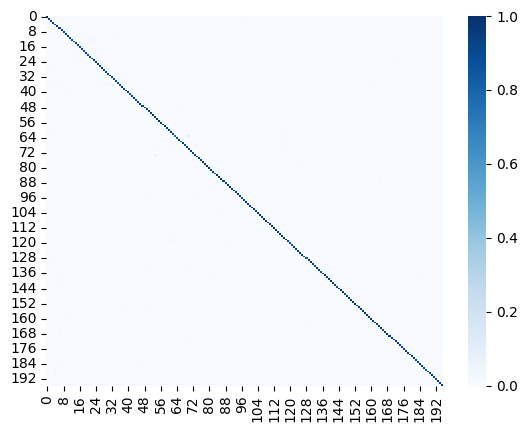

In [44]:
# plot confusion matrix as heatmap

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(cm, cmap="Blues")

In [25]:
# show and save the classification report (precision, recall, f1-score, support)

from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv("reports/effnetv2b3-batch64-ep120.csv")

print(report_df)

                               precision    recall  f1-score       support
AM General Hummer SUV 2000      0.977778  0.988764  0.983240     89.000000
Acura RL Sedan 2012             0.808219  0.921875  0.861314     64.000000
Acura TL Sedan 2012             0.919540  0.930233  0.924855     86.000000
Acura TL Type-S 2008            0.930233  0.952381  0.941176     84.000000
Acura TSX Sedan 2012            0.787234  0.913580  0.845714     81.000000
...                                  ...       ...       ...           ...
Volvo XC90 SUV 2007             0.932584  0.965116  0.948571     86.000000
smart fortwo Convertible 2012   0.987179  0.962500  0.974684     80.000000
accuracy                        0.941913  0.941913  0.941913      0.941913
macro avg                       0.943414  0.941775  0.941930  16131.000000
weighted avg                    0.943513  0.941913  0.942069  16131.000000

[199 rows x 4 columns]


### Model Serving

Finally we can try to simulate an API endpoint by taking an base64 encoded image as input and performing inference on it after decoding and preprocessing it. The `test_ims` folder contain some car images found online. After testing this short snippet, it can be easily ported to the FastAPI app as a POST endpoint.

In [34]:
# predict on an image first base64 encoded then decoded to simulate the api

test_image_request = {
    "image": base64.b64encode(Path("Stanford Cars Dataset/test_ims/bentleycgtc2007.jpg").read_bytes()).decode("utf-8")
}

test_image = Image.open(io.BytesIO(base64.b64decode(test_image_request["image"])))
test_image = test_image.resize((IMG_SIZE, IMG_SIZE))
test_image = np.array(test_image)
test_image = tf.keras.applications.efficientnet_v2.preprocess_input(test_image)
test_image = np.expand_dims(test_image, axis=0)

pred = test_model.predict(test_image)
pred = np.argmax(pred, axis=1)
print(f"Predicted class: {class_names[pred[0]]}")

1/1 [==============================] - 1s 1s/step
Predicted class: Bentley Continental GT Coupe 2007
